**Universidade Federal de Pernambuco – Centro de Informática**

**Residência em Visão Computacional – CIn/Samsung**

**Prof. Tsang Ing Ren**

**Disciplina de Visão Computacional 2**

__

**Aluna:** Arianne Santos da Macena.

Para o problema de reconhecimento de faces, ao invés da saída ser o rótulo/label de uma classe, a saída será um array de valores reais que representam características de uma face. Esse processo pode ser chamado de "quantificar" uma face e esses vetores também podem ser chamados de "*embeddings*". Cada modelo de rede neural pode produzir *embeddings* de diferentes tamanhos.

Além disso, uma arquitetura indicada para o problema de reconhecimento de faces é a [Rede Neural Siamesa](http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf). 

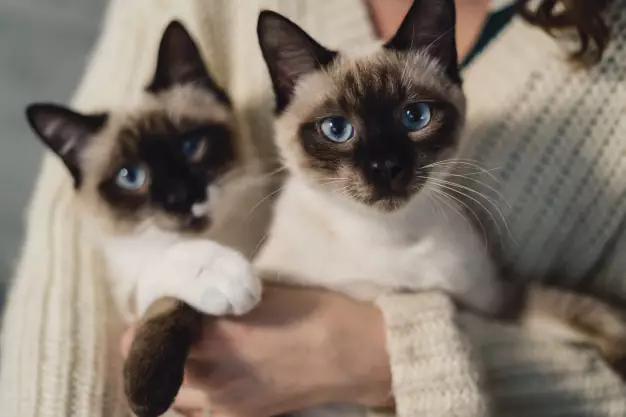

Essa rede performa a chamada "One-shot classification" que dado duas imagens, ela tenta prever se são da mesma "classe", retornando uma probabilidade.
Essa rede também pode ser usada para problemas de: verificação de assinatura, comparação de impressão digital, avaliação de severidade de doença, similaridade de texto, etc.

Boa parte desse código foi inspirado no tutorial do keras no seguinte link: https://keras.io/examples/vision/siamese_contrastive

In [ ]:
from glob import glob
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Leitura dos dados

## Obtendo imagens

In [ ]:
!unzip TinyVGGFace2-Train.zip -d train
!ls train

Archive:  TinyVGGFace2-Train.zip
replace train/n000001/0273_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/n000001/0273_01.jpg  
  inflating: train/n000001/0089_01.jpg  
  inflating: train/n000001/0251_01.jpg  
  inflating: train/n000001/0257_01.jpg  
  inflating: train/n000001/0069_01.jpg  
  inflating: train/n000001/0213_01.jpg  
  inflating: train/n000001/0394_01.jpg  
  inflating: train/n000001/0010_01.jpg  
  inflating: train/n000001/0434_02.jpg  
  inflating: train/n000001/0102_01.jpg  
  inflating: train/n000001/0115_01.jpg  
  inflating: train/n000001/0294_01.jpg  
  inflating: train/n000001/0118_04.jpg  
  inflating: train/n000001/0113_01.jpg  
  inflating: train/n000001/0451_01.jpg  
  inflating: train/n000001/0327_01.jpg  
  inflating: train/n000001/0270_01.jpg  
  inflating: train/n000001/0365_01.jpg  
  inflating: train/n000001/0167_01.jpg  
  inflating: train/n000001/0032_01.jpg  
  inflating: train/n000001/0485_02.jpg  
  inflating: train/n000001/0220

In [ ]:
!unzip TinyVGGFace2-Test.zip -d test
!ls test

Archive:  TinyVGGFace2-Test.zip
replace test/n001299/0089_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/n001299/0089_01.jpg  
  inflating: test/n001299/0168_01.jpg  
  inflating: test/n001299/0069_01.jpg  
  inflating: test/n001299/0113_01.jpg  
  inflating: test/n001299/0167_01.jpg  
  inflating: test/n001299/0178_01.jpg  
  inflating: test/n001299/0201_01.jpg  
  inflating: test/n001299/0190_01.jpg  
  inflating: test/n001299/0102_04.jpg  
  inflating: test/n001299/0159_04.jpg  
  inflating: test/n001299/0151_01.jpg  
  inflating: test/n001299/0407_01.jpg  
  inflating: test/n001299/0248_01.jpg  
  inflating: test/n001299/0015_02.jpg  
  inflating: test/n001299/0156_01.jpg  
  inflating: test/n001299/0153_03.jpg  
  inflating: test/n001299/0191_03.jpg  
  inflating: test/n001299/0114_01.jpg  
  inflating: test/n001299/0028_01.jpg  
  inflating: test/n001299/0037_01.jpg  
  inflating: test/n001299/0108_02.jpg  
  inflating: test/n001299/0195_01.jpg  
  inflating: t

## Imagens x Labels

In [ ]:
DIMS = 64 # tamanho escolhido arbitrariamente
INPUT_SHAPE = (DIMS, DIMS, 3)

In [ ]:
def get_images_labels_by_generator(generator):
  """Esse método retorna as imagens e labels criados por um gerador keras 

  Arguments:
      generator: iterator do tipo DirectoryIterator 

  Returns:
      Dois numpy arrays contendo imagens e labels correspondentes.
  """

  print(f"Class indices: {generator.class_indices}")

  images = []
  labels = []
  generator_len = len(generator)
  train_images_it_len = generator_len - 1

  for idx, train_data in enumerate(tqdm(generator)):
    # train_data[0][0].shape image
    # train_data[1][0] label
    # labels[np.argmax(train_data[1][0])]

    images.append(train_data[0][0])
    labels.append(np.argmax(train_data[1][0]))

    if(idx == train_images_it_len):
      break

  return np.array(images), np.array(labels)

In [ ]:
data_generator = ImageDataGenerator()       

train_iterator = data_generator.flow_from_directory(
    'train',
    target_size = (DIMS, DIMS),
    batch_size =  1,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False
)

test_iterator = data_generator.flow_from_directory(
    'test',
    target_size = (DIMS, DIMS),
    batch_size =  1,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False
)

Found 3895 images belonging to 10 classes.
Found 1603 images belonging to 5 classes.


In [ ]:
test_images, test_labels = get_images_labels_by_generator(test_iterator)
print("\n", len(test_images))
print(len(test_labels))

Class indices: {'n001299': 0, 'n001303': 1, 'n001337': 2, 'n001341': 3, 'n001368': 4}


100%|█████████▉| 1602/1603 [00:01<00:00, 911.74it/s]


 1603
1603


In [ ]:
train_val_images, train_val_labels = get_images_labels_by_generator(train_iterator)
print("\n", len(train_val_images))
print(len(train_val_labels))

Class indices: {'n000001': 0, 'n000029': 1, 'n000040': 2, 'n000078': 3, 'n000082': 4, 'n000106': 5, 'n000129': 6, 'n000149': 7, 'n000178': 8, 'n000284': 9}


100%|█████████▉| 3894/3895 [00:04<00:00, 812.69it/s] 



 3895
3895


In [ ]:
train_val_images.shape

(3895, 64, 64, 3)

In [ ]:
# divisão do conjunto de treinamento em 50/50 para treinamento da rede
x_train, x_val, y_train, y_val = train_test_split(train_val_images, train_val_labels, train_size=0.5)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1947, 64, 64, 3)
(1947,)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(1948, 64, 64, 3)
(1948,)


# Criação de pares

## Criação

In [ ]:
def make_pairs(x, y):
    """Esse método cria um a tupla que contém pares de imagens com o seus labels correspondentes.

    Arguments:
        x: Lista contendo imagens (em formato de array), cada índice dessa lista corresponde a UMA imagem.
        y: Lista contendo labels de imagens (em formato de array), cada label é do tipo inteiro.

    Returns:
        Uma tupla contendo dois numpy arrays: (par com amostras de imagens, labels),
        o par com amostras tem o formato: (2 * tamanho de x, 2, formato da imagem)
        e as labels tem o formato: (2 * tamanaho de x).
    """

    # calcula o número total de classes presentes no dataset
    # e cria uma lista dos índices de cada label dado todos as amostras
    # dado um label específico
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):

        # adiciona uma amostra correta
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # adiciona uma amostra incorreta
        label2 = np.random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = np.random.randint(0, num_classes - 1)

        idx2 = np.random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
pairs_train, labels_train = make_pairs(x_train, y_train)

In [ ]:
print(pairs_train.shape)
print(labels_train.shape)

(3894, 2, 64, 64, 3)
(3894,)


In [ ]:
pairs_val, labels_val = make_pairs(x_val, y_val)
print(pairs_val.shape)
print(labels_val.shape)

(3896, 2, 64, 64, 3)
(3896,)


In [ ]:
pairs_test, labels_test = make_pairs(test_images, test_labels)
print(pairs_test.shape)
print(labels_test.shape)

(3206, 2, 64, 64, 3)
(3206,)


In [ ]:
# divisão dos grupos de pares correspondentes a pares de amostras de pessoas iguais e pessoas diferentes (x1 e x2 no método make_pairs)
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]
print(x_train_1.shape, x_train_2.shape)

(3894, 64, 64, 3) (3894, 64, 64, 3)


In [ ]:
x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]
print(x_val_1.shape, x_val_2.shape)

(3896, 64, 64, 3) (3896, 64, 64, 3)


In [ ]:
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]
print(x_test_1.shape, x_test_2.shape)

(3206, 64, 64, 3) (3206, 64, 64, 3)


## Visualização

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Plota pares de imagens e suas respectivas lables, e predições se for o conjunto de teste.

    Arguments:
        pairs: Pares de images no formato de numpy arrays,
               no formato: (quantidade de pares, 2, dimensao da imagem, dimensao da imagem)
        to_show: Inteiro que representa o número de exemplos para visualização (valor padrão é 6).
                 Esse valor deve ser múltiplo do valor definido para "num_col",
                 caso contrário, ele dividido se for maior que "num_col",
                 e incrementado se for menor.
        num_col: Inteiro que representa a quantidade de imagens a serem visualizadas em uma linha (valor padrão é 3).
                 Para visualização de imagens do conjunto de teste e treinamento, o valor de num_col não deve exceder
                 a 3 e 7, respectivamente.
        predictions: Numpy array com valores das predições com formato: (to_show, 1).
                     Deve ser passado quando test = True.
        test: Booleano que diz quando os dados dos pares passados por parâmetro são do conjunto de treinamento
              ou de teste.

    Returns:
        None.
    """

    # Se to_show % num_col != 0
    #    divida to_show,
    #       para dividir to_show limite num_row até que
    #       to_show % num_col == 0
    #
    # Se to_show//num_col == 0
    #    então significa que num_col é maior que to_show
    #    logo, incremente to_show
    #       para incrementar to_show atribua 1 à num_row
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    #  to_show deve ser multiplo de num_col
    #  para to_show ser multiplo de num_col
    #  atribuimos num_row * num_col à to_show
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col)
    for i in range(to_show):

        # Se o número de linhas for 1, o array tem uma dimensão
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0].astype(np.uint8), pairs[i][1].astype(np.uint8)], axis=1))
        ax.set_axis_off()
        answer = {"label": "Same person", "color": "green"} if labels[i] else {"label": "Different person", "color": "red"}
        if test:
            ax.set_title("{} ({:.2f} %)".format(answer['label'], predictions[i][0]*100), fontdict={'color': answer['color']})
        else:
            ax.set_title(f"{answer['label']}", fontdict={'color': answer['color']})
    if test:
        plt.tight_layout(rect=(0, 0, 2, 2), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

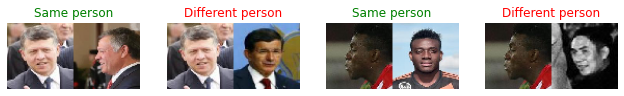

In [ ]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

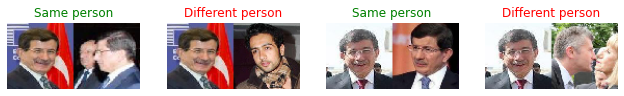

In [ ]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

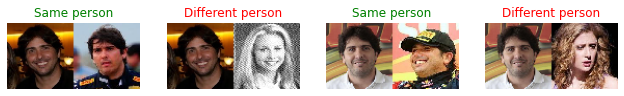

In [ ]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

# Distância euclidiana

Modelos usados para reconhecimento de face são modelos CNN convencionais que representam imagens como vetores. A similaridade entre esses vetores pode dizer se duas fotos de um rosto é da mesma pessoa. Essa similaridade pode ser calculada usando medidas como Similaridade do Cosseno, Distância Euclidiana e a Norma L2. Para essa lista, será usada a distância euclidiana.

In [ ]:
def euclidean_distance(vects):
    """Esse método encontra a distância euclidiana entre dois arrays.

    Arguments:
        vects: Lista contendo dois arrays (tensores) com o mesmo tamanho.

    Returns:
        Array (tensor) contendo a distância euclidiana entre os arrays passados por parâmetro.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

# Constrative loss

Além da função de perda binary cross-entropy, existem outras opções que podem ser bem usadas em cojunto com Redes Neurais Siamesas, como por exemplo a Constrative loss e a Triplet loss. [A mais comum é a Constrative loss](https://towardsdatascience.com/how-to-choose-your-loss-when-designing-a-siamese-neural-net-contrastive-triplet-or-quadruplet-ecba11944ec), e ela será usada nessa lista. Essa função é definida pela equação abaixo:

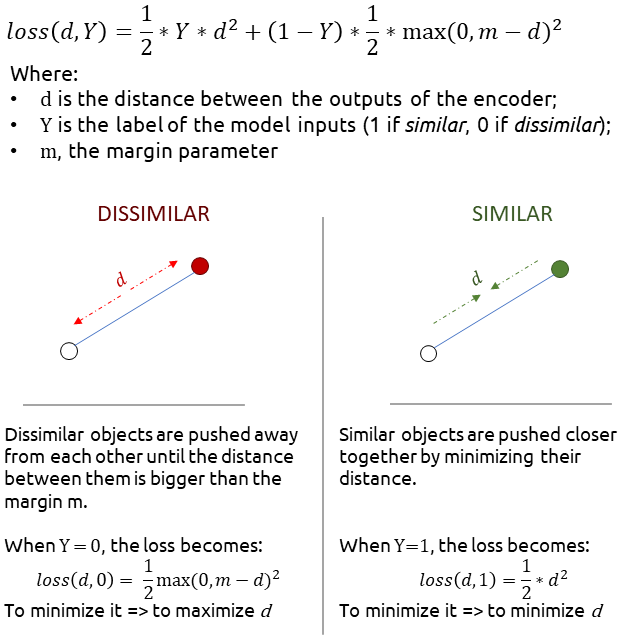

In [ ]:
def loss(margin=1):
    """Esse método retorna uma função que calcula o valor de constrative loss

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).
      margin: Inteiro que define o valor baseline para a distância para quais pares
              devem ser classificados como diferentes.

  Returns:
      função "constrative_loss" usando o dado do parâmetro "margin".
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Esse método calcula a constrative loss.

      Arguments:
          y_true: Lista de labels.
          y_pred: Lista de predições do mesmo tamanho que y_true

      Returns:
          Um array (tensor) contendo o valor de constrative loss.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

# Definição do modelo

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

In [ ]:
# https://keras.io/examples/vision/siamese_network/#setting-up-the-embedding-generator-model
def get_siamese_nn(input_shape):
  base_cnn = ResNet50(weights="imagenet", input_shape=input_shape, include_top=False)

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256, activation="relu")(dense1)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256)(dense2)

  embedding = Model(base_cnn.input, output)

  trainable = False
  for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

  return embedding

In [ ]:
model = get_siamese_nn(INPUT_SHAPE)

input_1 = layers.Input(INPUT_SHAPE)
input_2 = layers.Input(INPUT_SHAPE)

# Mesma estrutura de rede para ambas as ~ redes irmãs ~ siamesas.
sis_1 = get_siamese_nn(INPUT_SHAPE)(input_1)
sis_2 = get_siamese_nn(INPUT_SHAPE)(input_2)

merge_layer = layers.Lambda(euclidean_distance)([sis_1, sis_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese_nn = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
siamese_nn.compile(loss=loss(margin=1), optimizer=optimizers.Adam(0.0001), metrics=["accuracy"])
siamese_nn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 256)          27982720    ['input_2[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 256)          27982720    ['input_3[0][0]']                
                                                                                            

# Treinamento da rede

In [ ]:
history = siamese_nn.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=16,
    epochs=20,
)

Epoch 1/20
244/244 [==============================] - 38s 77ms/step - loss: 0.3107 - accuracy: 0.4797 - val_loss: 0.2935 - val_accuracy: 0.5667
Epoch 2/20
244/244 [==============================] - 20s 83ms/step - loss: 0.2106 - accuracy: 0.6836 - val_loss: 0.2419 - val_accuracy: 0.6101
Epoch 3/20
244/244 [==============================] - 15s 63ms/step - loss: 0.1633 - accuracy: 0.7704 - val_loss: 0.2243 - val_accuracy: 0.6407
Epoch 4/20
244/244 [==============================] - 20s 83ms/step - loss: 0.1319 - accuracy: 0.8413 - val_loss: 0.2157 - val_accuracy: 0.6512
Epoch 5/20
244/244 [==============================] - 20s 83ms/step - loss: 0.1135 - accuracy: 0.8893 - val_loss: 0.2110 - val_accuracy: 0.6653
Epoch 6/20
244/244 [==============================] - 15s 63ms/step - loss: 0.0952 - accuracy: 0.9268 - val_loss: 0.2058 - val_accuracy: 0.6833
Epoch 7/20
244/244 [==============================] - 15s 63ms/step - loss: 0.0845 - accuracy: 0.9407 - val_loss: 0.2077 - val_accuracy:

## Visualizar resultado

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

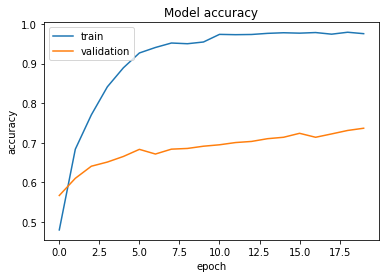

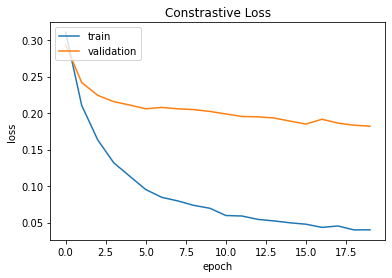

In [ ]:
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

# Teste da rede

In [ ]:
results = siamese_nn.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

101/101 [==============================] - 4s 36ms/step - loss: 0.2534 - accuracy: 0.6101
test loss, test acc: [0.25343871116638184, 0.6101060509681702]


In [ ]:
predictions = siamese_nn.predict([x_test_1, x_test_2])

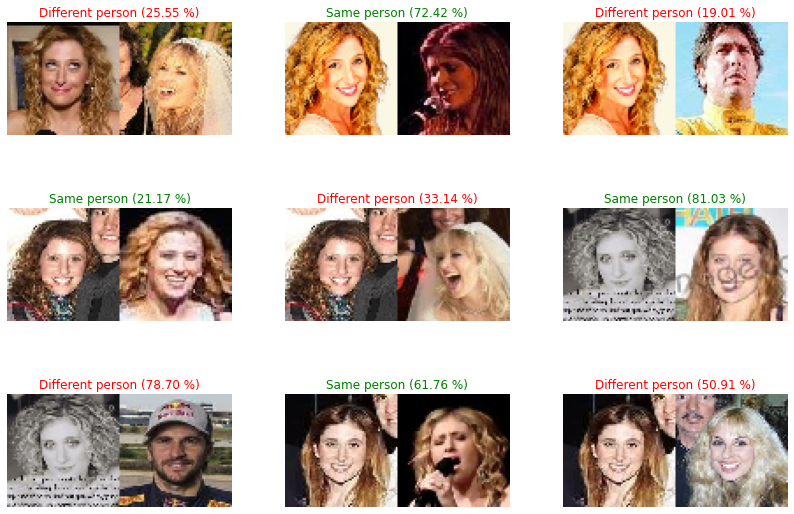

In [ ]:
random_number = np.random.randint(0, len(pairs_test)-1)
visualize(pairs_test[random_number:], labels_test[random_number:], to_show=9, predictions=predictions, test=True)

# Bônus

Uma opção para análise de atributos faciais e reconhecimento de face pode ser o framework chamado Deepface. Esse framework permite a utilização de diversos modelos estado-da-arte (VGG, Google FaceNet, OpenFace, Facebook DeepFace, DeepID, ArcFace, Dlib, SFace, SSD, MTCNN, RetinaFace e MediaPipe) além de medidas de similaridade citadas no tópico de Distância euclidiana.

In [ ]:
!pip install deepface

     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 87 kB 7.4 MB/s 
     |████████████████████████████████| 2.3 MB 62.3 MB/s 
     |████████████████████████████████| 462 kB 63.7 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=ff2d29ced0f9434857f8da1e26631f674ad53e6b6c72af23be80d7ecad8f2af3
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have im

In [ ]:
from deepface import DeepFace

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
result = DeepFace.verify(img1_path = "/content/train/n000082/0001_01.jpg", img2_path = "/content/test/n001368/0002_01.jpg")
result

{'detector_backend': 'opencv',
 'distance': 0.5971069640788087,
 'model': 'VGG-Face',
 'similarity_metric': 'cosine',
 'threshold': 0.4,
 'verified': False}